In [1]:
from openbox import space as sp
import numpy as np
import matplotlib.pyplot as plt
import openbox.surrogate
from openbox.surrogate.base.base_model import AbstractModel
from openbox.acquisition_function import AbstractAcquisitionFunction, EI
from openbox import Advisor
from scipy import stats
from openbox import logger
norm = stats.norm
import so_benchmark_function as sof
import soc_benchmark_function as socf
from openbox import Optimizer

In [31]:
def branin_grad(X):
    x1 = X[0]
    x2 = X[1]
    gd = np.array([2 * (x2 - (5.1 / (4 * np.pi ** 2)) * x1 ** 2 + 5 * x1 / np.pi - 6) * (-5.1 / (2 * np.pi ** 2) + 5 / np.pi) - 10 * (1 - 1 / (8 * np.pi)) * np.sin(x1), 2 * (x2 - (5.1 / (4 * np.pi ** 2)) * x1 ** 2 + 5 * x1 / np.pi - 6)])
    return gd

def ackley_grad(X):
    a = 20
    b = 0.2
    c = 2 * np.pi
    n = len(X)
    t1 = a * b * np.exp(-b * np.sqrt(np.mean(X ** 2))) * X / (np.sqrt(n * X @ X))
    t2 = np.exp(np.mean(np.cos(c * X))) * np.sin(X) *c / n
    t3 = a + np.exp(1)
    gd = t1 + t2 + t3
    return gd

def beale_grad(X):
    
    x1 = X[0]
    x2 = X[1]
    part1 = 2 * (1.5 - x1 + x1 * x2) * np.array([- 1 + x2, x1])
    part2 = 2 * (2.25 - x1 + x1 * x2 ** 2) * np.array([- 1 + x2 ** 2, 2 * x1 * x2])
    part3 = 2 * (2.625 - x1 + x1 * x2 ** 3) * np.array([- 1 + x2 ** 3, 3 * x1 * x2 ** 2])
    gd = part1 + part2 + part3
    return gd

def hartmann_grad(X):
    a = np.array([
        [10, 3, 17, 3.5, 1.7, 8],
        [0.05, 10, 17, 0.1, 8, 14],
        [3, 3.5, 1.7, 10, 17, 8],
        [17, 8, 0.05, 10, 0.1, 14],
    ])
    c = np.array([1.0, 1.2, 3.0, 3.2])
    p = np.array([
        [0.1312, 0.1696, 0.5569, 0.0124, 0.8283, 0.5886],
        [0.2329, 0.4135, 0.8307, 0.3736, 0.1004, 0.9991],
        [0.2348, 0.1451, 0.3522, 0.2883, 0.3047, 0.6650],
        [0.4047, 0.8828, 0.8732, 0.5743, 0.1091, 0.0381],
    ])
    inner_sum = np.sum(a * (X - p) ** 2, axis=1)
    y = -np.sum(c * np.exp(-inner_sum))
    return

grads = [branin_grad, ackley_grad, beale_grad, hartmann_grad]

In [39]:
class PI(AbstractAcquisitionFunction):
    def __init__(self,
                 model,
                 par: float = 0.0,
                 **kwargs):

        r"""Computes the probability of improvement for a given x over the best so far value as
        acquisition value.

        :math:`P(f_{t+1}(\mathbf{X})\geq f(\mathbf{X^+})) :=
        \Phi(\frac{\mu(\mathbf{X}) - f(\mathbf{X^+})}{\sigma(\mathbf{X})})`,
        with :math:`f(X^+)` as the incumbent and :math:`\Phi` the cdf of the standard normal

        Parameters
        ----------
        model : AbstractEPM
            A surrogate that implements at least
                 - predict_marginalized_over_instances(X)
        par : float, default=0.0
            Controls the balance between exploration and exploitation of the
            acquisition function.
        """
        super(PI, self).__init__(model)
        self.long_name = 'Probability of Improvement'
        self.par = par
        self.eta = None

    def _compute(self, X: np.ndarray, **kwargs):
        """Computes the PI value.

        Parameters
        ----------
        X: np.ndarray(N, D)
           Points to evaluate PI. N is the number of points and D the dimension for the points

        Returns
        -------
        np.ndarray(N, 1)
            PI of X
        """
        if self.eta is None:
            raise ValueError('No current best specified. Call update('
                             'eta=<float>) to inform the acquisition function '
                             'about the current best value.')

        if len(X.shape) == 1:
            X = X[:, np.newaxis]
        m, var_ = self.model.predict_marginalized_over_instances(X)
        std = np.sqrt(var_)
        return stats.norm.cdf((self.eta - m - self.par) / std)

class myEI(AbstractAcquisitionFunction):
    r"""Computes for a given x the expected improvement as
    acquisition value.

    :math:`EI(X) := \mathbb{E}\left[ \max\{0, f(\mathbf{X^+}) - f_{t+1}(\mathbf{X}) - \xi \} \right]`,
    with :math:`f(X^+)` as the incumbent.
    """

    def __init__(self,
                 model: AbstractModel,
                 par: float = 0.0,
                 alpha: float = 0.1,
                 **kwargs):
        """Constructor

        Parameters
        ----------
        model : AbstractEPM
            A surrogate that implements at least
                 - predict_marginalized_over_instances(X)
        par : float, default=0.0
            Controls the balance between exploration and exploitation of the
            acquisition function.
        """

        super(myEI, self).__init__(model)
        self.long_name = 'Expected Improvement'
        self.par = par
        self.alpha = alpha
        self.eta = None

    def _compute(self, X: np.ndarray, **kwargs):
        """Computes the EI value and its derivatives.

        Parameters
        ----------
        X: np.ndarray(N, D), The input points where the acquisition function
            should be evaluated. The dimensionality of X is (N, D), with N as
            the number of points to evaluate at and D is the number of
            dimensions of one X.

        Returns
        -------
        np.ndarray(N, 1)
            Expected Improvement of X
        """
        if len(X.shape) == 1:
            X = X[:, np.newaxis]

        m, v = self.model.predict_marginalized_over_instances(X)
        s = np.sqrt(v)

        if self.eta is None:
            raise ValueError('No current best specified. Call update('
                             'eta=<int>) to inform the acquisition function '
                             'about the current best value.')

        def calculate_f():
            z = (self.eta - m - self.par) / s
            return (self.eta - m - self.par) * norm.cdf(z) + s * norm.pdf(z)

        if np.any(s == 0.0):
            # if std is zero, we have observed x on all instances
            # using a RF, std should be never exactly 0.0
            # Avoid zero division by setting all zeros in s to one.
            # Consider the corresponding results in f to be zero.
            logger.warning("Predicted std is 0.0 for at least one sample.")
            s_copy = np.copy(s)
            s[s_copy == 0.0] = 1.0
            f = calculate_f()
            f[s_copy == 0.0] = 0.0
        else:
            f = calculate_f()
        if (f < 0).any():
            raise ValueError(
                "Expected Improvement is smaller than 0 for at least one "
                "sample.")

        gdp = self.model.grad_dot_product
        gds = self.model.grad_sum
        return f + self.alpha * (gds @ X[-1] - gdp)

# opt = Optimizer(problem.evaluate_config, problem.get_configspace(), max_runs=50, surrogate_type='gp')
# myAdvisor = Advisor(opt.config_space)
# from openbox.acq_optimizer.basic_maximizer import RandomSearchMaximizer
# # myAdvisor.acq_optimizer = RandomSearchMaximizer
# myAdvisor.acquisition_function = PI(opt.config_advisor.surrogate_model)
# opt.config_advisor = myAdvisor
# history_PI = opt.run()

In [65]:
i = 0
name_list = ['branin', 'ackley', 'beale', 'hartmann']
name = name_list[i]
problem = sof.get_problem(name)
grad_func = grads[i]

In [66]:
from openbox.core.generic_advisor import myAdvisor

opt = Optimizer(problem.evaluate_config, problem.get_configspace(), max_runs=50, surrogate_type='gp')
history = opt.run()

opt = Optimizer(problem.evaluate_config, problem.get_configspace(), max_runs=50, surrogate_type='gp')
Advisor1 = myAdvisor(opt.config_space, grad_func=grad_func)
Advisor1.acquisition_function = myEI(opt.config_advisor.surrogate_model, alpha = 1)
opt.config_advisor = Advisor1
history_PI = opt.run()

[2024-06-21 22:25:34,267][OpenBox][INFO][color_logger.py:203] Logfile: j:\学习\23-24-2\机器学习中的优化方法\Project\logs\OpenBox_2024-06-21-22-25-34-266838.log
[2024-06-21 22:25:34,279][OpenBox][INFO][generic_advisor.py:240] [BO auto selection]  acq_type: ei. acq_optimizer_type: random_scipy.
  0%|          | 0/50 [00:00<?, ?it/s][2024-06-21 22:25:34,286][OpenBox][WARNING][util_funcs.py:126] Provide result as <dict> that contains "objectives" is recommended, got <class 'numpy.float64'>
[2024-06-21 22:25:34,291][OpenBox][WARNING][util_funcs.py:73] The shape of objectives is changed from () to (1,).
[2024-06-21 22:25:34,297][OpenBox][INFO][generic_smbo.py:310] Iter 1, objectives: [24.129964413622268].
[2024-06-21 22:25:34,302][OpenBox][WARNING][util_funcs.py:126] Provide result as <dict> that contains "objectives" is recommended, got <class 'numpy.float64'>
[2024-06-21 22:25:34,307][OpenBox][WARNING][util_funcs.py:73] The shape of objectives is changed from () to (1,).
[2024-06-21 22:25:34,313][Open

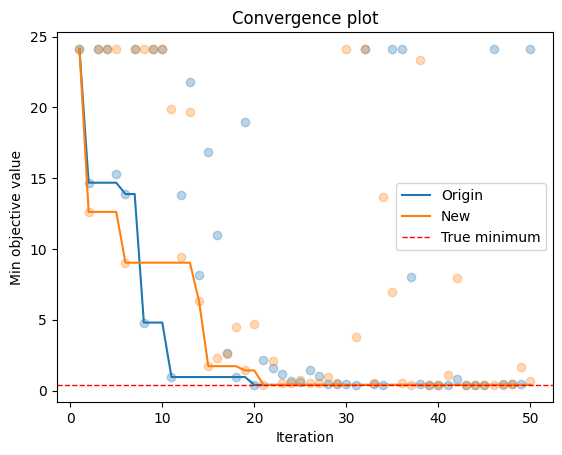

In [67]:
fig = plt.figure()
ax = fig.gca()
history.plot_convergence(ax=ax, color='C0', name='Origin')
history_PI.plot_convergence(ax=ax, color='C1', name='New')

ax.axhline(problem.optimal_value, linestyle="--", color="r", lw=1, label="True minimum")
ax.legend()
plt.show()

In [68]:
opt.config_advisor.surrogate_model.grad_update_round

43